In [1]:
#!pip install pyheif

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import os
from PIL import Image
import numpy as np
#import pyheif 
#from tqdm.notebook import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

C:\Users\_v010ch_\Anaconda3\envs\uly22\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from pillow_heif import register_heif_opener

register_heif_opener()

In [32]:
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [6]:
test_img_names = set(os.listdir(DIR_DATA_TEST))
train_img_names = set(os.listdir(DIR_DATA_TRAIN))

#test_img_names = set(os.listdir('NordClan/participants/test'))
#train_img_names = set(os.listdir('NordClan/participants/train'))

In [7]:
print(test_img_names.intersection(train_img_names))

set()


In [8]:
train_labels_df = pd.read_csv(os.path.join(DIR_DATA, 'train.csv'), sep=';', index_col=None)

In [9]:
train_labels_names = set(train_labels_df['image_name'].values)

In [10]:
train_labels_names.intersection(test_img_names)

set()

In [11]:
len(train_labels_names.intersection(train_img_names)) == len(train_img_names)

True

In [12]:
train_labels_df['image_name'].value_counts().head(5)

img_1596.jpg    1
img_2536.jpg    1
img_2570.jpg    1
img_2568.jpg    1
img_2563.jpg    1
Name: image_name, dtype: int64

In [13]:
img_name = 'img_1596' + '.jpg'
train_labels_df[train_labels_df['image_name'] == img_name]

,image_name,distance
0,img_1596.jpg,4.88


C:\Users\_v010ch_\AppData\Local\Temp\ipykernel_18152\1371075936.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((640, 640), Image.ANTIALIAS)


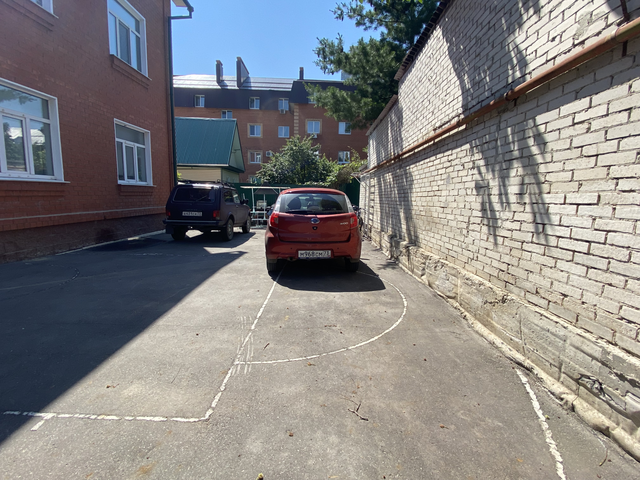

In [14]:
img = Image.open(os.path.join(DIR_DATA_TRAIN, img_name))
img.thumbnail((640, 640), Image.ANTIALIAS)
img

## Train / test

In [15]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.classes = [0, 2]  # person and car

Using cache found in C:\Users\_v010ch_/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-8-3 Python-3.10.4 torch-1.12.0 CUDA:0 (GeForce GTX 1050 Ti, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [16]:
_ = model.cpu()

In [17]:
train_data = []

for img_name in tqdm(train_img_names): 
    #if 'heic' in img_name:
    #    heif_file = pyheif.read(os.path.join(DIR_DATA_TRAIN, img_name))
    #   img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
    #else:
    #    img = Image.open(os.path.join(DIR_DATA_TRAIN, img_name))
    img = Image.open(os.path.join(DIR_DATA_TRAIN, img_name))
    
    results = model(np.array(img))
    #results.tocpu()
    if results.xyxy[0].shape != torch.Size([0, 6]):
        results = [img_name] + results.xyxy[0][0].numpy().tolist()
        train_data.append(results)

100%|████████████████████████████████████████████████████████████████████████████████| 530/530 [05:04<00:00,  1.74it/s]


In [18]:
train_data_df = pd.DataFrame(train_data, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])

In [19]:
train_data_df = pd.merge(train_labels_df, train_data_df, how='left')

In [21]:
from catboost import CatBoostRegressor

In [22]:
%%time
model_2 = CatBoostRegressor()

# Fit model
model_2.fit(train_data_df[['x_min', 'y_min', 'x_max', 'y_max', 'conf']], train_data_df[['distance']].values)

Learning rate set to 0.037035
0:	learn: 1.7181374	total: 187ms	remaining: 3m 7s
1:	learn: 1.6847708	total: 189ms	remaining: 1m 34s
2:	learn: 1.6510780	total: 191ms	remaining: 1m 3s
3:	learn: 1.6184379	total: 192ms	remaining: 47.8s
4:	learn: 1.5901233	total: 194ms	remaining: 38.6s
5:	learn: 1.5581755	total: 195ms	remaining: 32.3s
6:	learn: 1.5310256	total: 197ms	remaining: 27.9s
7:	learn: 1.5042203	total: 198ms	remaining: 24.5s
8:	learn: 1.4779394	total: 199ms	remaining: 21.9s
9:	learn: 1.4511401	total: 201ms	remaining: 19.9s
10:	learn: 1.4265604	total: 202ms	remaining: 18.1s
11:	learn: 1.4024600	total: 203ms	remaining: 16.7s
12:	learn: 1.3790130	total: 205ms	remaining: 15.6s
13:	learn: 1.3577798	total: 207ms	remaining: 14.5s
14:	learn: 1.3353871	total: 208ms	remaining: 13.7s
15:	learn: 1.3155273	total: 209ms	remaining: 12.9s
16:	learn: 1.2962178	total: 210ms	remaining: 12.2s
17:	learn: 1.2757646	total: 212ms	remaining: 11.5s
18:	learn: 1.2574785	total: 213ms	remaining: 11s
19:	learn: 1

In [24]:
test_data = []

for img_name in tqdm(test_img_names): 
    #if 'heic' in img_name:
    #    heif_file = pyheif.read(os.path.join('NordClan/participants/test/', img_name))
    #    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
    #else:
    #    img = Image.open(os.path.join('NordClan/participants/test/', img_name))
    img = Image.open(os.path.join(DIR_DATA_TEST, img_name))
    results = model(np.array(img))
    if results.xyxy[0].shape != torch.Size([0, 6]):
        results = [img_name] + results.xyxy[0][0].numpy().tolist()
        test_data.append(results)

100%|████████████████████████████████████████████████████████████████████████████████| 521/521 [04:38<00:00,  1.87it/s]


In [25]:
test_data_df = pd.DataFrame(test_data, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])

In [26]:
preds = model_2.predict(test_data_df[['x_min', 'y_min', 'x_max', 'y_max', 'conf']])

In [27]:
test_data_df['distance'] = preds

In [28]:
sample_solution_df = test_data_df[['image_name', 'distance']]

In [29]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
    lost_test_items.append([file_name, 0])

In [30]:
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])

In [31]:
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

In [33]:
sample_solution_df.to_csv(os.path.join(DIR_SUBM, 'baseline.csv'), sep=';', index=False)